# -----PSEU PANEL 5------

## LOAD LIBRARIES

In [1]:
import glob as glob
import pandas as pd
from upsetplot import generate_counts
from upsetplot import from_contents
from upsetplot import UpSet
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
from itertools import combinations
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy import stats
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
import os

# Set seaborn plotting theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

colors_input = {
  "RNA004_HEK293T_A" : "#EE6C4D",
  "RNA004_HEK293T_B" : "#E69581",
  "RNA004_blood_1" :"#0B3954",
  "RNA004_blood_IVT_1" :"#8b5cf6",
  "RNA004_UHRR_1" : "#098C9A",
  "RNA004_UHRR_2" : "#26AFBE",
  "RNA004_UHRR_3" : "#93C6CC", 
  "RNA004_blood_2" : "#177BB5",
  "RNA004_blood_3" : "#38A6E5",
  "RNA004_blood_IVT_3" : "#BA9EFA",
}

## LOAD REFERENCE GENES

In [2]:
import pyranges as pr
def parse_gtf(gtf_path):
    genes = []
    opener = gzip.open if gtf_path.endswith(".gz") else open
    with opener(gtf_path, "rt") as f:
        for line in f:
            if line.startswith("#") or "\tgene\t" not in line:
                continue
            parts = line.strip().split("\t")
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            gene_id = None
            gene_name = None
            gene_type = None
            for attr in attributes.split(";"):
                if "gene_id" in attr:
                    gene_id = attr.split('"')[1]
                if "gene_name" in attr:
                    gene_name = attr.split('"')[1]
                if "gene_type" in attr:
                    gene_type = attr.split('"')[1]
                if gene_id and gene_name and gene_type:
                    break
            if gene_id:
                genes.append({
                    "gene_id": gene_id,
                    "chrom": chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "gene_name" : gene_name,
                    "gene_type" : gene_type
                })
    return genes

GTF_PATH = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/BEDMETHYL_files/last_filter_round/test/gencode.v43.sorted.gtf"  # Can be gzipped (.gtf.gz)
gene_list = parse_gtf(GTF_PATH)
genes_df = pd.DataFrame.from_dict(gene_list)
gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))


# LOAD PSEU SITES FROM MODKIT

## BLOOD

In [3]:
replace_dict = {
    'RNA004_blood' : 'RNA004_blood_1',
    'RNA004_blood_IVT' : 'RNA004_blood_IVT_1',
    'RNA004_S6_IVT_merged' : 'RNA004_blood_IVT_3',
    'RNA004_S5_DRS' : 'RNA004_blood_2',
    'RNA004_S6_DRS': 'RNA004_blood_3',
    'RNA004_A' : 'RNA004_HEK293T_A',
    'RNA004_B': 'RNA004_HEK293T_B'
}

In [4]:
blood_RNA004_pseu = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*blood*pse*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*S*DRS*pse*r1.mod.bed")
new_blood_RNA004_pseu = "/home/awiercze/RNA004_S5_DRS_basecall.0.7.2.GRCh38_pse*.r1.mod.rna002_cov.bed"
new_blood3_RNA004_pseu = "/home/awiercze/RNA004_S6_DRS_basecall.0.7.2.GRCh38_pse*.r1.mod.rna002_cov.bed"
blood_RNA004_pseu.append("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT_pseu.r1.mod.bed")

In [5]:
blood_RNA004_pseu

['/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood.0.7.2.GRCh38_pseu.r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood_IVT.0.7.2.GRCh38_pseu.r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_pseu.r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S6_DRS_basecall.0.7.2.GRCh38_pseu.r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT_pseu.r1.mod.bed']

In [6]:
p_pseu = pd.DataFrame()
    
for j in blood_RNA004_pseu:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    #print(len(t_tmp))

    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    caller = "Dorado@v5.0.0"
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]
    t_tmp["sample"] = j.split("/")[-1].replace("_basecall.0.7.2.GRCh38_pseu.r1.mod.bed", "").replace(".0.7.2.GRCh38_pseu.r1.mod.bed", "").replace("merged_RNA004_S6_IVT_pseu.r1.mod.bed", "RNA004_S6_IVT_merged")
    modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
    mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    #print(len(t_tmp))
    t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
    #print(len(t_tmp))
    sample_name = j.split("/")[-1]
    for word, initial in replace_dict.items():
        sample_name = sample_name.replace(word, initial)
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    p_pseu = pd.concat([p_pseu, t_tmp], axis = 0)
p_pseu = p_pseu.reset_index()
p_pseu = p_pseu.drop("index", axis = 1)
p_pseu["chromStart"] = p_pseu["chromStart"].astype(int)
p_pseu["chromEnd"] = p_pseu["chromEnd"].astype(int)
p_pseu["coverage"] = p_pseu["coverage"].astype(int)
p_pseu["modRatio"] = p_pseu["modRatio"].astype(float)
    
# Create unique identifier per position
p_pseu["pos"] = p_pseu["chrom"] + ":" + p_pseu["chromStart"].astype(str) + "" + p_pseu["strand"]

# Use only sites on chr1-22,Y,X,M
p_pseu = p_pseu[p_pseu["chrom"].str.contains("chr")]
# Filter table for covered sites 
p_pseu_cov10 = p_pseu[(p_pseu["coverage"] >= 10)]

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood.0.7.2.GRCh38_pseu.r1.mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood_IVT.0.7.2.GRCh38_pseu.r1.mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S6_DRS_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT_pseu.r1.mod.bed


In [9]:
p_pseu_cov10.columns

Index(['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'coverage', 'modRatio', 'sample', 'RNA004_UHRR_2', 'RNA004_UHRR_1',
       'RNA004_blood_IVT', 'RNA002_B', 'RNA002_blood_IVT', 'RNA004_blood',
       'RNA002_UHRR_1', 'RNA002_blood', 'RNA004_UHRR_3', 'RNA004_A',
       'RNA002_A', 'RNA004_B', 'RNA004_S6_DRS', 'RNA004_S6_IVT_LI',
       'RNA004_S6_IVT', 'RNA004_S5_DRS', 'caller', 'chemistry', 'pos'],
      dtype='object')

## CELL-LINES

In [ ]:
cell_lines_RNA004_pseu = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*_A*pse*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*_B*pse*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*UHRR*pse*r1.mod.bed")


In [ ]:
p_cell_pseu = pd.DataFrame()
    
for j in cell_lines_RNA004_pseu:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    #print(len(t_tmp))

    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    caller = "Dorado@v5.0.0"
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]
    t_tmp["sample"] = j.split("/")[-1].replace("_basecall.0.7.2.GRCh38_pseu.r1.mod.bed", "").replace(".0.7.2.GRCh38_pseu.r1.mod.bed", "").replace("merged_RNA004_S6_IVT_pseu.r1.mod.bed", "RNA004_S6_IVT_merged")
    modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
    mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    #print(len(t_tmp))
    t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
    #print(len(t_tmp))
    sample_name = j.split("/")[-1]
    for word, initial in replace_dict.items():
        sample_name = sample_name.replace(word, initial)
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    p_cell_pseu = pd.concat([p_cell_pseu, t_tmp], axis = 0)
p_cell_pseu = p_cell_pseu.reset_index()
p_cell_pseu = p_cell_pseu.drop("index", axis = 1)
p_cell_pseu["chromStart"] = p_cell_pseu["chromStart"].astype(int)
p_cell_pseu["chromEnd"] = p_cell_pseu["chromEnd"].astype(int)
p_cell_pseu["coverage"] = p_cell_pseu["coverage"].astype(int)
p_cell_pseu["modRatio"] = p_cell_pseu["modRatio"].astype(float)
    
# Create unique identifier per position
p_cell_pseu["pos"] = p_cell_pseu["chrom"] + ":" + p_cell_pseu["chromStart"].astype(str) + "" + p_cell_pseu["strand"]


p_cell_pseu = p_cell_pseu[p_cell_pseu["chrom"].str.contains("chr")]
# Filter table for covered sites
p_cell_pseu_cov10 = p_cell_pseu[(p_cell_pseu["coverage"] >= 10)]

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_A_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
40930052
40930052
40930052
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_B_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
54685081
54685081
54685081
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_1_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
32316441
32316441
32316441
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_2_basecall.0.7.2.GRCh38_pseu.r1.mod.bed
31738531
31738531
31738531
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_3.0.7.2.GRCh38_pseu.r1.mod.bed
69779238
69779238
69779238


# Concatenate blood, UHRR and HEK293T pseU site tables

In [43]:
# Concatenate Blood and Cell-lines table of all pseu sites
pseu_all_samples = pd.concat([p_cell_pseu_cov10, p_pseu_cov10], axis = 0)


In [44]:
pseu_all_samples_cov_pseu = pseu_all_samples[pseu_all_samples["modRatio"] >= 10]

# CREATE MAIN OUTPUT TABLE PSEU

In [ ]:
# LOAD GENE ANNOTATION FROM GENCODE
def parse_gtf(gtf_path):
    genes = []
    opener = gzip.open if gtf_path.endswith(".gz") else open
    with opener(gtf_path, "rt") as f:
        for line in f:
            if line.startswith("#") or "\tgene\t" not in line:
                continue
            parts = line.strip().split("\t")
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            gene_id = None
            gene_name = None
            gene_type = None
            for attr in attributes.split(";"):
                if "gene_id" in attr:
                    gene_id = attr.split('"')[1]
                if "gene_name" in attr:
                    gene_name = attr.split('"')[1]
                if "gene_type" in attr:
                    gene_type = attr.split('"')[1]
                if gene_id and gene_name and gene_type:
                    break
            if gene_id:
                genes.append({
                    "gene_id": gene_id,
                    "chrom": chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "gene_name" : gene_name,
                    "gene_type" : gene_type
                })
    return genes

GTF_PATH = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/BEDMETHYL_files/last_filter_round/test/gencode.v43.sorted.gtf"  # Can be gzipped (.gtf.gz)
gene_list = parse_gtf(GTF_PATH)
genes_df = pd.DataFrame.from_dict(gene_list)



In [41]:
# LOAD STOPP CODON SITES FROM GENCODE
stopp_codons = pd.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/TEST_folder/ANNO_misc/gencodev43.stopp_codon.bed", sep  = "\t", header = None, names = ["Chromosome", "Start", "End", "type", "Strand", "Transcript"])
stopp_codons["type"] = "STOP CODON"

# LOAD pseU SITES FROM RMBase
cols_mod_file = ["Chromosome","Start","End","modID", "Score", "Strand","modType", "supportNum", "supportList", "supportListSub","pubList","cellList","seqTypeList","geneID", "transcriptID","geneName","geneType" ,"Region", "Seq", "motifScore","conservedSitesList","snoRNA_detailInfo","snoRNA_guideSite","snoRNA_nameList","snoRNA_dataBase","writerLoc","writerID","writerNameList","source"]
rmbase_sites = pd.read_csv("~/NEW_RNA004_PLOTS/human.hg38.Pseudo.result.col29.bed", sep = "\t", header = None, names = cols_mod_file)
rmbase_sites = rmbase_sites[rmbase_sites["Chromosome"].str.contains("chr")]
rmbase_sites["type"] = "RMBase"
rmbase_sites["pos"] =  rmbase_sites["Chromosome"].astype(str) + ":" + rmbase_sites["Start"].astype(str) + rmbase_sites["Strand"].astype(str)

# LOAD pseU SITES FROM TAVAKOLI et al.
tava = "/home/jensenone/psu_high_conf_0base.bed"
tava_sites = pd.read_csv(tava, sep = "\t", header = None)
tava_sites["type"] = "Tavakoli et al."
tava_sites.columns = ["Chromosome", "Start", "End", "type"]
tava_sites["pos"] = tava_sites["Chromosome"].astype(str) + ":" + tava_sites["Start"].astype(str) 

# LOAD pseU SITES FROM PRAISE
praise = "/raid/awiercze_analysis/RNA004_REVISION_NAR/PRAISE_pseU_sites.txt"
praise_sites = pd.read_csv(praise, sep = "\t")
praise_sites = praise_sites[~praise_sites["chr_site"].str.contains("NONE")]
praise_sites["Chromosome"] = [i.split("_")[0] for i in praise_sites["chr_site"]]
praise_sites = praise_sites[praise_sites["Chromosome"].str.contains("chr")]
praise_sites["Position"] = [i.split("_")[1] for i in praise_sites["chr_site"]]
praise_sites = praise_sites[~praise_sites["Position"].str.contains("K")]
praise_sites = praise_sites[~praise_sites["Position"].str.contains("G")]
praise_sites = praise_sites[~praise_sites["Position"].str.contains("M")]
praise_sites["Start"] = [int(i.split("-")[0]) if "-" in i else i for i in praise_sites["Position"] ]
praise_sites["End"] = [i.split("-")[1] if "-" in i else int(i) + 1 for i in praise_sites["Position"] ]
praise_sites = praise_sites[["Chromosome", "Start", "End", "gene_name"]]
praise_sites["type"] = "PRAISE"
strands = []
new_starts = []
new_ends = []
for i, row in praise_sites.iterrows():
    start = int(row["Start"])
    end = int(row["End"])
    if start > end: 
        strands.append("-")
        new_starts.append(end)
        new_ends.append(start)
    else:
        strands.append("+")
        new_starts.append(start)
        new_ends.append(end)
praise_sites["Start"] = new_starts
praise_sites["End"] = new_ends
praise_sites["Strand"] = strands

## ANNOTATE ALL SITES 

In [ ]:
# Add tissue label per site 
pseu_all_samples = pseu_all_samples_cov_pseu
pseu_all_samples["sample_type"] = "blood"
pseu_all_samples.loc[pseu_all_samples["sample"].str.contains("UHRR"), "sample_type"] = "UHRR"
pseu_all_samples.loc[pseu_all_samples["sample"].str.contains("_[A|B]"), "sample_type"] = "HEK293T"
pseu_all_samples.loc[pseu_all_samples["sample"].str.contains("IVT"), "sample_type"] = "blood_IVT"


pseu_all_samples_cov_pseU = pseu_all_samples

# Create copy of table
df = pseu_all_samples[pseu_all_samples.pos.isin(pseu_all_samples_cov_pseU["pos"].drop_duplicates())]


pos_cols = ['chrom', 'chromStart', 'chromEnd', 'strand']

# Check if site is covered and modified in at least sample per tissue
df['pseU_ratio>=10.RNA004_Dorado_blood'] =(df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'blood')
df['pseU_ratio>=10.RNA004_Dorado_blood_IVT'] =(df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'blood_IVT')
df['pseU_ratio>=10.RNA004_Dorado_UHRR'] = (df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'UHRR')
df['pseU_ratio>=10.RNA004_Dorado_HEK293T'] =(df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'HEK293T')

df_grouped = df.groupby(pos_cols).agg({
    'pseU_ratio>=10.RNA004_Dorado_blood': 'any',
    'pseU_ratio>=10.RNA004_Dorado_blood_IVT': 'any',
    'pseU_ratio>=10.RNA004_Dorado_UHRR': 'any',
    'pseU_ratio>=10.RNA004_Dorado_HEK293T': 'any'}).astype(int).reset_index()

# Extract modRatio per site and sample
modratios = df.pivot_table(index=pos_cols, columns='sample', values='modRatio', aggfunc='first').reset_index()
modratios.columns.name = None  # remove index name
samples = ["pseU_freq." + s for s in modratios.columns[4:].to_list()]
my_dict = dict(zip(modratios.columns[4:].to_list(), samples))
modratios = modratios.rename(columns = my_dict)

# Extract mean modRatio per tissue and site
mean_modratios_cells = df.groupby(pos_cols + ['sample_type'])['modRatio'].mean().unstack().reset_index()
mean_modratios_cells.columns.name = None
mean_modRatio_Dorado_cells = mean_modratios_cells.rename(columns={
    "blood" : 'avg_pseU_ratio.RNA004_Dorado_blood',
    "blood_IVT" : 'avg_pseU_ratio.RNA004_Dorado_blood_IVT',
    'UHRR': 'avg_pseU_ratio.RNA004_Dorado_UHRR',
    'HEK293T': 'avg_pseU_ratio.RNA004_Dorado_HEK293T',
})
# Calculate number of tissues with modified site
df['modified'] = ((df['coverage'] >= 10) & (df['modRatio'] >= 10)).astype(int)
detected_tissues = df[(df['modified'] == 1)].groupby(pos_cols)['sample_type'].nunique().reset_index(name='Dorado_tissues_detected')

# Merge all subtables
result = df_grouped.merge(mean_modRatio_Dorado_cells, on=pos_cols, how='outer').merge(detected_tissues, on = pos_cols, how = "outer").merge(modratios, on=pos_cols, how='outer')

# Remove sites that are not modified in any sample
result_sub = result[~result["Dorado_tissues_detected"].isna()]

# Add gene annotation per site
query_ranges = pr.PyRanges(result_sub.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))

query_ranges = pr.PyRanges(result.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))
result_annot_genes = gtf_ranges.join(query_ranges)
result_annot_genes_df = result_annot_genes.df
result_annot_genes_df["pos"] = result_annot_genes_df["Chromosome"].astype(str) + result_annot_genes_df["End_b"].astype(str) + result_annot_genes_df["Strand_b"].astype(str)
annot_pseu_pos = result_annot_genes_df[["gene_id", "gene_name",  "gene_type", "pos"]].drop_duplicates().groupby("pos")[["gene_id", "gene_name",  "gene_type"]].agg(lambda x: ', '.join(sorted(set(x)))).reset_index()
result["pos"] = result["chrom"].astype(str) + result["chromEnd"].astype(str) + result["strand"].astype(str)
result_annot = pd.merge(annot_pseu_pos, result, how = "right", on = "pos")

result_annot = gtf_ranges.join(query_ranges, suffix = "_Pos")
result_annot_df = result_annot.df.rename(columns = {"Start" : "Start_gene", "End" : "End_gene", "Start_Pos" : "Start", "End_Pos" : "End"})
# Add pseu Databases annotation per site
query_stopp = (pr.PyRanges(result_annot_df)
    .join(pr.PyRanges(stopp_codons), how = "left", suffix = "_SC")
    .join(pr.PyRanges(rmbase_sites), suffix = "_RMBase", how = "left")
    .join(pr.PyRanges(praise_sites), how="left", suffix = "_PRAISE")
    .join(pr.PyRanges(tava_sites), how="left", suffix = "_Tavakoli")
)
result_annot2_df = query_stopp.df
result_annot2_df = result_annot2_df.replace(np.nan, "NA")



join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [84]:
mendeliom = pd.read_csv("/raid/awiercze_analysis/RESEARCH/REVISION_FIGURES/mendeliom_IHDB.tsv", sep = "\t")
result_annot2_df["gene_id_flat"] = [i.split('.')[0] for i in result_annot2_df.gene_id]
result_annot2_df["Mendeliome"] = (result_annot2_df["gene_id_flat"].isin(mendeliom.ensembl_gene_id)).astype(int)

In [ ]:
result_annot2_df = result_annot2_df[[ 'gene_name', 'gene_type','gene_id', 'Mendeliome','Chromosome', 
        'Start', 'End', 'Strand_Pos','Dorado_tissues_detected',
       'pseU_ratio>=10.RNA004_Dorado_blood',
       'pseU_ratio>=10.RNA004_Dorado_blood_IVT',
       'pseU_ratio>=10.RNA004_Dorado_UHRR',
       'pseU_ratio>=10.RNA004_Dorado_HEK293T',
       'avg_pseU_ratio.RNA004_Dorado_blood',
       'avg_pseU_ratio.RNA004_Dorado_blood_IVT',
       'avg_pseU_ratio.RNA004_Dorado_UHRR',
       'avg_pseU_ratio.RNA004_Dorado_HEK293T','pseU_freq.RNA004_blood','pseU_freq.RNA004_S5_DRS', 'pseU_freq.RNA004_S6_DRS', 'pseU_freq.RNA004_blood_IVT', 'pseU_freq.RNA004_S6_IVT_merged',
       'pseU_freq.RNA004_A', 'pseU_freq.RNA004_B', 
       'pseU_freq.RNA004_UHRR_1', 'pseU_freq.RNA004_UHRR_2',
       'pseU_freq.RNA004_UHRR_3', 
       'type', 'type_RMBase', 'type_PRAISE', 'type_Tavakoli']]
result_annot2_df = result_annot2_df.rename(columns = {"type" : "stop codon", "type_RMBase" : "RMBase", "type_PRAISE" : "PRAISE", "type_Tavakoli" : "Tavakoli et al."})

result_annot2_df.columns = [i.replace("_A", "_HEK293T_A").replace("_B", "_HEK293T_B").replace("_S5_DRS", "_blood_2").replace("_S6_DRS", "_blood_3").replace("_S6_IVT_merged", "_blood_IVT_3") for i in result_annot2_df.columns]
result_annot2_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_pseu_annot_NEW2_genes.tsv", sep = "\t", index = False)

In [ ]:
#result_pseu = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_pseU_annot_NEW.tsv", sep = "\t")
#result_pseu[result_pseu["gene_name"] != "-1"].to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_pseu_annot_NEW2_genes.tsv", sep = "\t", index = False)

# CREATE ALL CORRELATIONS

In [ ]:
result_rows = []
df = pseu_all_samples

# Extract unique samples
samples = df['sample'].unique()

# Iterate over all pairwise combinations of all samples to calculate pseu ratio correlations between shared pseU sites
for s1, s2 in combinations(samples, 2):
    print(s1 + " vs " + s2)

        
    df1 = df[df['sample'] == s1]
    df2 = df[df['sample'] == s2]

    # Filtered sets
    df1_cov = df1[df1['coverage'] >= 10]
    df2_cov = df2[df2['coverage'] >= 10]

    df1_mod = df1_cov[df1_cov['modRatio'] >= 10]
    df2_mod = df2_cov[df2_cov['modRatio'] >= 10]


    # Positions with coverage >= 10 and modRatio >= 10
    pos_mod1 = set(df1_mod['pos'])
    pos_mod2 = set(df2_mod['pos'])

    # Joined positions
    joined_cov_mod = pos_mod1 & pos_mod2
    
    # Overlap input:
    if s2 == "RNA004_S6_IVT_merged":
        df1_mod_joined = df1_mod[(df1_mod["RNA004_S6_IVT"]  + df1_mod["RNA004_S6_IVT_LI"]) >= 10]
    else:
        df1_mod_joined = df1_mod[df1_mod[s2] >= 10]
    if s1 == "RNA004_S6_IVT_merged":
        df2_mod_joined = df2_mod[(df2_mod["RNA004_S6_IVT"]  + df2_mod["RNA004_S6_IVT_LI"]) >= 10]
    else:
        df2_mod_joined = df2_mod[df2_mod[s1] >= 10]
    joined_cov = set(df1_mod_joined['pos']) | set(df2_mod_joined['pos'])
    
    if joined_cov_mod:
        df1_r2 = df1_mod[df1_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_mod[df2_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_r2.sort_values(by = "pos")
        df1_r2 = df1_r2.sort_values(by = "pos")
        mod1 = df1_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        mod2 = df2_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        r = pearsonr(mod1, mod2)
        r = r[0]
        corr = round(r, 4)
        
        #input_set1 = df1_r2
        #input_set2 = df2_r2
        #m = pd.merge(input_set1.reset_index(), input_set2.reset_index(), how = "inner", on = "pos")
        #g = sns.jointplot(x="modRatio_x", y="modRatio_y", data=m, kind='hex', color="#0B3954",     height=3,        # default is 6
        #    ratio=5 )

        # Add correlation coefficient as text
        #g.fig.suptitle(f'Correlation (r) = {corr:.2f}' + f'\n(n = {len(m)})', fontsize=10)
        #g.set_axis_labels(s1,s2)
        #g.ax_joint.set_ylim(0, 100) 
        #g.ax_joint.set_xlim(0, 100) 
        #g.fig.subplots_adjust(top=0.9)  # make room for suptitle
        #comp = s1 + "_vs_" + s2
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".pseU.png", transparent=True, dpi = 300)
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".pseU.pdf", transparent=True, dpi = 300)
        #plt.close()
    else:
        corr = float('nan')

    result_rows.append({
        'Sample1': s1,
        'Sample2': s2,
        'n_pseU_ratio>=10.Sample1': len(pos_mod1),
        'n_pseU_ratio>=10.Sample2': len(pos_mod2),
        'n_coverage_filter_passed*.Sample1_Sample2': len(joined_cov),
        'n_pseU_ratio>=10.Sample1_joined_cov': len(df1_mod_joined),
        'n_pseU_ratio>=10.Sample2_joined_cov': len(df2_mod_joined),
        'n_pseU_ratio>=10.Sample1_Sample2': len(joined_cov_mod),
        'mean_pseU_ratio.Sample1_joined_mod' : np.mean(mod1),
        'median_pseU_ratio.Sample1_joined_mod' : np.median(mod1),
        'mean_pseU_ratio.Sample2_joined_mod' : np.mean(mod2) ,
        'median_pseU_ratio.Sample2_joined_mod' : np.median(mod2) ,
        'Correlation_coeff_joined_cov_and_mod': corr
    })
    


RNA004_blood vs RNA004_blood_IVT
RNA004_blood vs RNA004_S5_DRS
RNA004_blood vs RNA004_S6_DRS
RNA004_blood vs RNA004_S6_IVT_merged
RNA004_blood vs RNA004_A
RNA004_blood vs RNA004_B
RNA004_blood vs RNA004_UHRR_1
RNA004_blood vs RNA004_UHRR_2
RNA004_blood vs RNA004_UHRR_3
RNA004_blood_IVT vs RNA004_S5_DRS
RNA004_blood_IVT vs RNA004_S6_DRS
RNA004_blood_IVT vs RNA004_S6_IVT_merged
RNA004_blood_IVT vs RNA004_A
RNA004_blood_IVT vs RNA004_B
RNA004_blood_IVT vs RNA004_UHRR_1
RNA004_blood_IVT vs RNA004_UHRR_2
RNA004_blood_IVT vs RNA004_UHRR_3
RNA004_S5_DRS vs RNA004_S6_DRS
RNA004_S5_DRS vs RNA004_S6_IVT_merged
RNA004_S5_DRS vs RNA004_A
RNA004_S5_DRS vs RNA004_B
RNA004_S5_DRS vs RNA004_UHRR_1
RNA004_S5_DRS vs RNA004_UHRR_2
RNA004_S5_DRS vs RNA004_UHRR_3
RNA004_S6_DRS vs RNA004_S6_IVT_merged
RNA004_S6_DRS vs RNA004_A
RNA004_S6_DRS vs RNA004_B
RNA004_S6_DRS vs RNA004_UHRR_1
RNA004_S6_DRS vs RNA004_UHRR_2
RNA004_S6_DRS vs RNA004_UHRR_3
RNA004_S6_IVT_merged vs RNA004_A
RNA004_S6_IVT_merged vs RNA004_

In [39]:
replace_dict = {
'RNA004_blood' : 'RNA004_blood_1',
 'RNA004_blood_IVT' :'RNA004_blood_IVT_1' ,
 'RNA004_S5_DRS':'RNA004_blood_2' ,
 'RNA004_S6_DRS':'RNA004_blood_3' ,
 'RNA004_S6_IVT_merged':'RNA004_blood_IVT_3' ,
 'RNA004_A':'RNA004_HEK293T_A' ,
 'RNA004_B':'RNA004_HEK293T_B' 
}

# Final result DataFrame
comparison_df = pd.DataFrame(result_rows)
comparison_df["Sample1"] = comparison_df["Sample1"].replace(replace_dict)
comparison_df["Sample2"] = comparison_df["Sample2"].replace(replace_dict)
comparison_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_r2_values_all_pairwise_comps_pseU_new.tsv", sep = "\t", index = False)

# CREATE COUNTS PLOTS AS BAR PLOT 

In [ ]:
pseu_all_samples.loc[pseu_all_samples["coverage"] >= 10, "LABEL"] = "cov >= 10 reads"
pseu_all_samples.loc[(pseu_all_samples["coverage"] >= 10) & (pseu_all_samples["modRatio"] >= 10), "LABEL"] = "pseU >= 10%"
pseu_all_samples_cov10 = pseu_all_samples[pseu_all_samples["coverage"] >= 10]

In [ ]:

total = pseu_all_samples_cov10.groupby('sample').size().reset_index(name="total_count")
covered = pseu_all_samples_cov10[pseu_all_samples_cov10.LABEL == 'cov >= 10 reads'].groupby("sample").size().reset_index(name="covered_count")
pseu = pseu_all_samples_cov10[pseu_all_samples_cov10.LABEL == 'pseU >= 10%'].groupby("sample").size().reset_index(name="pseu_count")
# Merge all counts
df = total.merge(covered, on='sample', how='left').merge(pseu, on='sample', how='left')
df.fillna(0, inplace=True)  # fill missing values with 0
# Calculate percentages
df['pseu_pct'] = df['pseu_count'] / df['covered_count'] * 100


In [ ]:
colors_input = {
  "RNA004_HEK293T_A" : "#EE6C4D",
  "RNA004_HEK293T_B" : "#E69581",
  "RNA004_blood_1" :"#0B3954",
  "RNA004_blood_IVT_1" :"#8b5cf6",
  "RNA004_UHRR_1" : "#098C9A",
  "RNA004_UHRR_2" : "#26AFBE",
  "RNA004_UHRR_3" : "#93C6CC", 
  "RNA004_blood_2" : "#177BB5",
  "RNA004_blood_3" : "#38A6E5",
  "RNA004_blood_IVT_3" : "#BA9EFA",
}

## TOTAL COUNTS WITH COVERAGE >= 10 AND MODRATIO >= 10

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data = df, hue = "sample", x="sample", edgecolor ="black", y="pseu_count",saturation=1, palette = colors_input)
ax.spines['left'].set_color('black')   # Left axis line
ax.spines['bottom'].set_color('black') 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):  # avoid labeling bars with NaN height
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 1,  # small offset above bar
            s=f"  {int(height)}",  # or f"{height:.1f}" for float
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=9,
            color = "gray"
        )
ax.set_ylabel("Total pseU sites (frequency >= 10)")
ax.set_xlabel("")
i = "all_samples"
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE4/PAPER_pseU_count_" + i + "_RNA004_tissue_bar.png", bbox_inches='tight', dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE4/PAPER_pseU_count_" + i + "_RNA004_tissue_bar.pdf", bbox_inches='tight', dpi=300)

## RMBASE

In [ ]:
new_df = pd.DataFrame()

for s in pseu_all_samples["sample"].drop_duplicates():
    print(s)
    df_sub = pseu_all_samples[pseu_all_samples["sample"] == s] 
    l_mod_sub = rmbase_sites[rmbase_sites["pos"].isin(df_sub.pos)]
    df_sig = df_sub[df_sub["modRatio"] >= 10]
    
    num_l_mod = df_sig[df_sig["pos"].isin(l_mod_sub.pos)]
    print(len(num_l_mod)/len(l_mod_sub))
    f = pd.DataFrame({"sample" : [s],
                      "num_cov_sites": [len(df_sub)],
                      "num_sig_sites": [len(df_sig)], 
                      "num_RMBase_cov" : [len(l_mod_sub)],
                      "perc_RMBase_mod" : [len(num_l_mod)/len(l_mod_sub)*100]})
    new_df = pd.concat([new_df, f], axis = 0)

In [ ]:

plt.figure(figsize=(5, 4))


ax = sns.barplot(x='sample', y='perc_RMBase_mod', data=new_df, hue = "sample", palette=colors_input, label='pseU sites', edgecolor = "black", order = sorted(df["sample"].drop_duplicates()))

bottom_bar = mpatches.Patch(color='#0b3954', label='pseU sites')

# Set labels
plt.ylabel('Percentage of RMBase pseU sites [%]')
plt.xlabel("")
df["sample_flat"] = df["sample"].str.replace("RNA004_", "")

for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):  # skip missing values
        ax.text(
            p.get_x() + 0.3 + p.get_width() / 2,
            height + 0.5,  # slightly above the bar
            f'{height:.1f}%',
            ha='center',
            va='bottom',rotation = 45,
            fontsize=8
        )

plt.xticks(ticks = sorted(df["sample"].drop_duplicates()), labels = sorted(df["sample_flat"].drop_duplicates()),rotation = 45, ha='right')
plt.tight_layout()

# show the graph

plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/SUPP_RMBase_pseu_amount_from_cov_sites.pdf", transparent = True, dpi = 300)
plt.show()

## TAVAKOLI SITES

In [ ]:
new_df_tava = pd.DataFrame()

for s in pseu_all_samples["sample"].drop_duplicates():
    print(s)
    df_sub = pseu_all_samples[pseu_all_samples["sample"] == s] 
    l_mod_sub2 = tava_sites[tava_sites["pos"].isin(df_sub.pos)]
    df_sig = df_sub[df_sub["modRatio"] >= 10]
    
    num_l_mod = df_sig[df_sig["pos"].isin(l_mod_sub2.pos)]
    print(len(num_l_mod)/len(l_mod_sub2))
    f = pd.DataFrame({"sample" : [s],
                      "num_cov_sites": [len(df_sub)],
                      "num_sig_sites": [len(df_sig)], 
                      "num_RMBase_cov" : [len(l_mod_sub2)],
                      "perc_RMBase_mod" : [len(num_l_mod)/len(l_mod_sub2)*100]})
    new_df_tava = pd.concat([new_df_tava, f], axis = 0)
plt.figure(figsize=(5, 4))


ax = sns.barplot(x='sample', y='perc_RMBase_mod', data=new_df_tava, saturation = 1, alpha = 1, hue = "sample", palette=colors_input, label='pseU sites', edgecolor = "black", order = sorted(df["sample"].drop_duplicates()))

bottom_bar = mpatches.Patch(color='#0b3954', label='pseU sites')

# Set labels
plt.ylabel('Percentage of Tavakoli pseU sites [%]')
plt.xlabel("")
df["sample_flat"] = df["sample"].str.replace("RNA004_", "")

for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):  # skip missing values
        ax.text(
            p.get_x() + 0.3 + p.get_width() / 2,
            height + 0.5,  # slightly above the bar
            f'{height:.1f}%',
            ha='center',
            va='bottom',rotation = 45,
            fontsize=8
        )

plt.xticks(ticks = sorted(df["sample"].drop_duplicates()), labels = sorted(df["sample_flat"].drop_duplicates()),rotation = 45, ha='right')
plt.tight_layout()

# show the graph

plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/SUPP_Tavakoli_pseu_amount_from_cov_sites.pdf", transparent = True, dpi = 300)
plt.show()

# PSEU OVERLAPS

## BLOOD

In [12]:
def plot_overlaps_blood(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"
    labels[2] = labels[2] + "\n(n=" + str(len(my_dict2[labels[2]]))  + ")"

    # Create Venn diagram
    venn = venn3(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('100').set_color("#1F97DD")   
    venn.get_patch_by_id('010').set_color("#53ABDF")   
    venn.get_patch_by_id('001').set_color("#84BADA")   
    venn.get_patch_by_id('110').set_color("#176796")   
    venn.get_patch_by_id('101').set_color("#4E7F9B")   
    venn.get_patch_by_id('111').set_color("#0B3954")  
    venn.get_patch_by_id('011').set_color("#5B839B")   


    venn.get_label_by_id('100').set_color("white")   
    venn.get_label_by_id('010').set_color("white")   
    venn.get_label_by_id('001').set_color("white")  
    venn.get_label_by_id('110').set_color("white")   
    venn.get_label_by_id('101').set_color("white")   
    venn.get_label_by_id('111').set_color("white")   
    venn.get_label_by_id('011').set_color("white")  

    venn.get_label_by_id('100').set_fontsize(7)
    venn.get_label_by_id('010').set_fontsize(7)
    venn.get_label_by_id('001').set_fontsize(7)
    venn.get_label_by_id('110').set_fontsize(7)
    venn.get_label_by_id('101').set_fontsize(7)
    venn.get_label_by_id('111').set_fontsize(17)
    venn.get_label_by_id('011').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())
    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_blood_RNA004_blood_cov10_freq10_pseu_replicates_" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

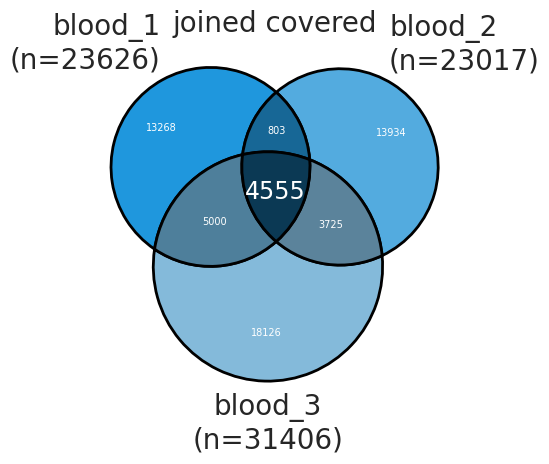

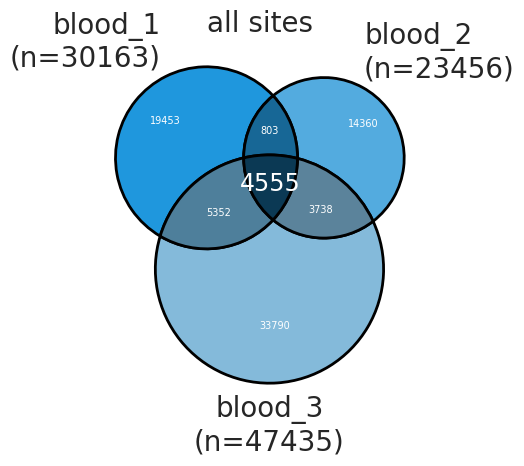

In [20]:
# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_blood") & (p_pseu_cov10["modRatio"] >= 10)]
blood_2_RNA004_pseu_sites = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_S5_DRS") & (p_pseu_cov10["modRatio"] >= 10)]
blood_3_RNA004_pseu_sites = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_S6_DRS") & (p_pseu_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_joined = blood_1_RNA004_pseu_sites[(blood_1_RNA004_pseu_sites["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_pseu_sites["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_pseu_sites_joined = blood_2_RNA004_pseu_sites[(blood_2_RNA004_pseu_sites["RNA004_blood"] >= 10 ) & (blood_2_RNA004_pseu_sites["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_pseu_sites_joined = blood_3_RNA004_pseu_sites[(blood_3_RNA004_pseu_sites["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_pseu_sites["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_joined.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_joined.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_joined.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "joined covered", out_name = "Blood_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites.pos), "blood_2" : set(blood_2_RNA004_pseu_sites.pos), "blood_3" : set(blood_3_RNA004_pseu_sites.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "all sites", out_name = "Blood_all_sites_RNA004_replicates")


###  SUBSTRACT IVT SITES (FALSE POSITIVES)

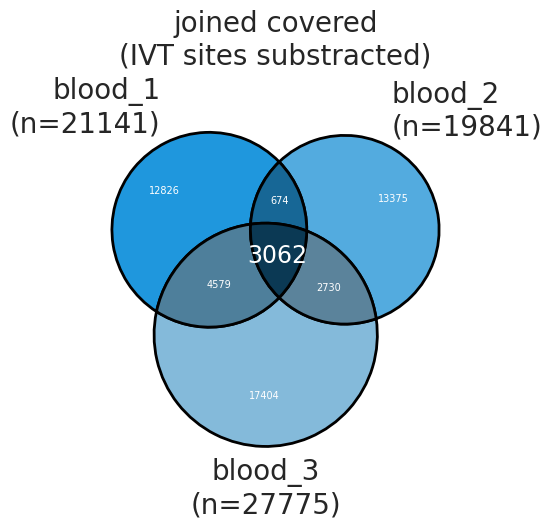

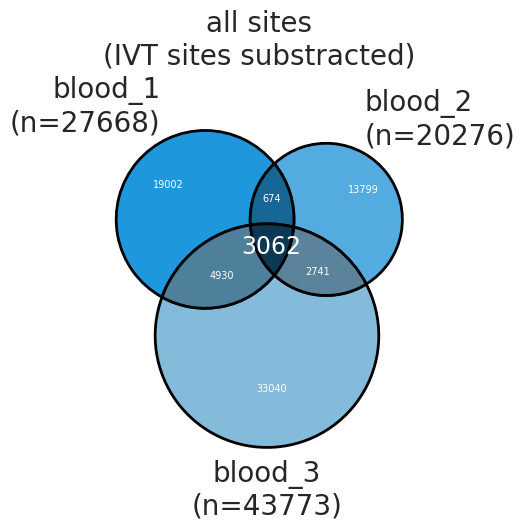

In [89]:
blood_IVT_RNA004_pseu_sites = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_S6_IVT_merged") & (p_pseu_cov10["modRatio"] >= 10)]


# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_IVTminus = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_blood") & (p_pseu_cov10["modRatio"] >= 10) & ~(p_pseu_cov10.pos.isin(blood_IVT_RNA004_pseu_sites.pos))]
blood_2_RNA004_pseu_sites_IVTminus = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_S5_DRS") & (p_pseu_cov10["modRatio"] >= 10) & ~(p_pseu_cov10.pos.isin(blood_IVT_RNA004_pseu_sites.pos))]
blood_3_RNA004_pseu_sites_IVTminus = p_pseu_cov10[(p_pseu_cov10["sample"] == "RNA004_S6_DRS") & (p_pseu_cov10["modRatio"] >= 10) & ~(p_pseu_cov10.pos.isin(blood_IVT_RNA004_pseu_sites.pos))]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_joined_IVTminus = blood_1_RNA004_pseu_sites_IVTminus[(blood_1_RNA004_pseu_sites_IVTminus["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_pseu_sites_IVTminus["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_pseu_sites_joined_IVTminus = blood_2_RNA004_pseu_sites_IVTminus[(blood_2_RNA004_pseu_sites_IVTminus["RNA004_blood"] >= 10 ) & (blood_2_RNA004_pseu_sites_IVTminus["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_pseu_sites_joined_IVTminus = blood_3_RNA004_pseu_sites_IVTminus[(blood_3_RNA004_pseu_sites_IVTminus["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_pseu_sites_IVTminus["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_joined_IVTminus.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_joined_IVTminus.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_joined_IVTminus.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "joined covered\n(IVT sites substracted)\n", out_name = "Blood_joined_RNA004_replicates_IVTminus")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_IVTminus.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_IVTminus.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_IVTminus.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "all sites\n(IVT sites substracted)\n", out_name = "Blood_all_sites_RNA004_replicates_IVTminus")

### MENDELIOME SITES ONLY

In [ ]:
query_ranges = pr.PyRanges(p_pseu_cov10.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
result_annot = gtf_ranges.join(query_ranges, how="right")
result_annot_df = result_annot.df



In [ ]:
mendeliom = pd.read_csv("/raid/awiercze_analysis/RESEARCH/REVISION_FIGURES/mendeliom_IHDB.tsv", sep = "\t")
result_annot_df["gene_id_flat"] = [i.split('.')[0] for i in result_annot_df.gene_id]
result_annot_df_mendel = result_annot_df[result_annot_df["gene_id_flat"].isin(mendeliom.ensembl_gene_id)]

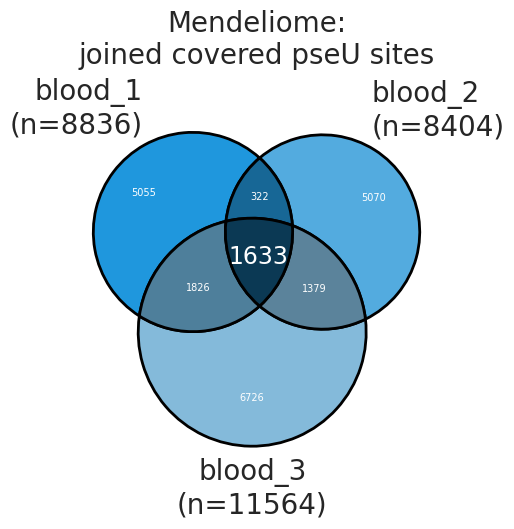

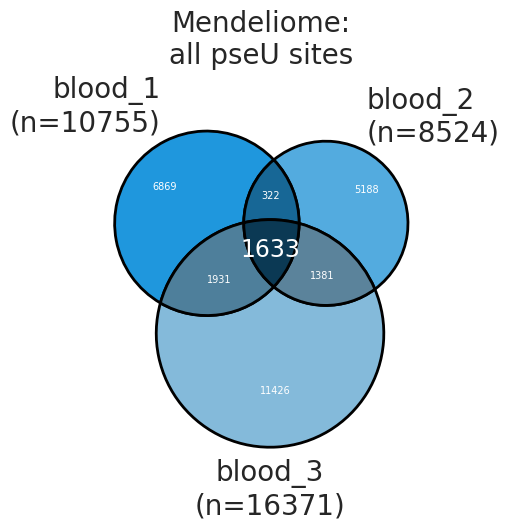

In [47]:
# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_blood") & (result_annot_df_mendel["modRatio"] >= 10)]
blood_2_RNA004_pseu_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_S5_DRS") & (result_annot_df_mendel["modRatio"] >= 10)]
blood_3_RNA004_pseu_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_S6_DRS") & (result_annot_df_mendel["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_joined_mendel = blood_1_RNA004_pseu_sites_mendel[(blood_1_RNA004_pseu_sites_mendel["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_pseu_sites_mendel["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_pseu_sites_joined_mendel = blood_2_RNA004_pseu_sites_mendel[(blood_2_RNA004_pseu_sites_mendel["RNA004_blood"] >= 10 ) & (blood_2_RNA004_pseu_sites_mendel["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_pseu_sites_joined_mendel = blood_3_RNA004_pseu_sites_mendel[(blood_3_RNA004_pseu_sites_mendel["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_pseu_sites_mendel["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_joined_mendel.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_joined_mendel.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_joined_mendel.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Mendeliome:\njoined covered pseU sites\n", out_name = "Blood_joined_mendel_sites_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_mendel.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_mendel.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_mendel.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Mendeliome:\nall pseU sites\n", out_name = "Blood_all_mendel_sites_RNA004_replicates")


### STOP CODON SITES ONLY

In [29]:
stopp_codons = pd.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/TEST_folder/ANNO_misc/gencodev43.stopp_codon.bed", sep  = "\t", header = None, names = ["Chromosome", "Start", "End", "type", "Strand", "Transcript"])
stopp_codons["type"] = "STOP CODON"

In [93]:
set_ranges = pr.PyRanges(stopp_codons)

query_ranges = pr.PyRanges(p_pseu_cov10.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
result_annot = set_ranges.join(query_ranges, how="right")
result_annot_df = result_annot.df


In [94]:
result_annot_df_stoppcodon = result_annot_df[result_annot_df["type"] == "STOP CODON"]


In [95]:
result_annot_df_stoppcodon.groupby("sample").size()

sample
RNA004_S5_DRS           54829
RNA004_S6_DRS           74500
RNA004_S6_IVT_merged    36712
RNA004_blood            63274
RNA004_blood_IVT        20802
dtype: int64

In [100]:
result_annot_df_stoppcodon_pseu = result_annot_df_stoppcodon[result_annot_df_stoppcodon["modRatio"] >= 10]

In [115]:
result_annot_df_stoppcodon_pseu.groupby("sample").pos.size()

sample
RNA004_S5_DRS           235
RNA004_S6_DRS           321
RNA004_S6_IVT_merged    156
RNA004_blood            150
RNA004_blood_IVT         68
Name: pos, dtype: int64

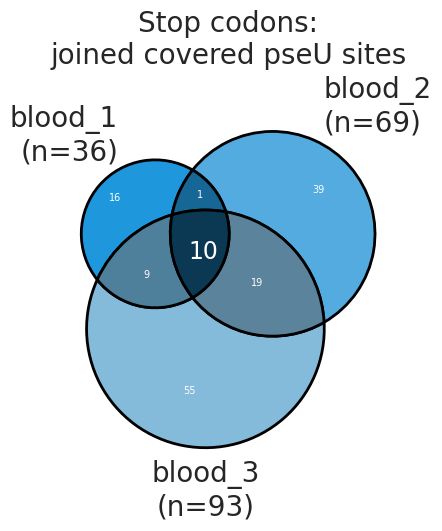

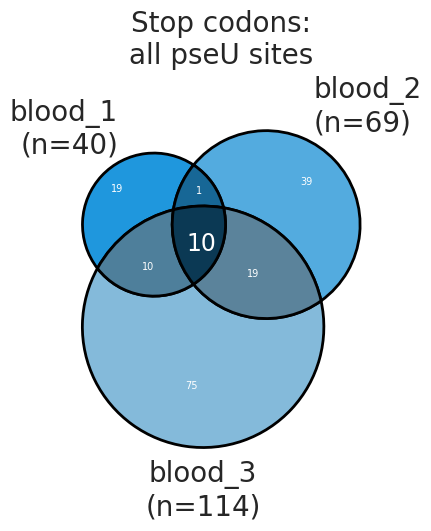

In [102]:
# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_stoppcodon = result_annot_df_stoppcodon[(result_annot_df_stoppcodon["sample"] == "RNA004_blood") & (result_annot_df_stoppcodon["modRatio"] >= 10)]
blood_2_RNA004_pseu_sites_stoppcodon = result_annot_df_stoppcodon[(result_annot_df_stoppcodon["sample"] == "RNA004_S5_DRS") & (result_annot_df_stoppcodon["modRatio"] >= 10)]
blood_3_RNA004_pseu_sites_stoppcodon = result_annot_df_stoppcodon[(result_annot_df_stoppcodon["sample"] == "RNA004_S6_DRS") & (result_annot_df_stoppcodon["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_pseu_sites_joined_stoppcodon = blood_1_RNA004_pseu_sites_stoppcodon[(blood_1_RNA004_pseu_sites_stoppcodon["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_pseu_sites_stoppcodon["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_pseu_sites_joined_stoppcodon = blood_2_RNA004_pseu_sites_stoppcodon[(blood_2_RNA004_pseu_sites_stoppcodon["RNA004_blood"] >= 10 ) & (blood_2_RNA004_pseu_sites_stoppcodon["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_pseu_sites_joined_stoppcodon = blood_3_RNA004_pseu_sites_stoppcodon[(blood_3_RNA004_pseu_sites_stoppcodon["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_pseu_sites_stoppcodon["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_joined_stoppcodon.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_joined_stoppcodon.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_joined_stoppcodon.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Stop codons:\njoined covered pseU sites\n", out_name = "Blood_joined_stoppcodon_sites_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_pseu_sites_stoppcodon.pos), "blood_2" : set(blood_2_RNA004_pseu_sites_stoppcodon.pos), "blood_3" : set(blood_3_RNA004_pseu_sites_stoppcodon.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Stop codons:\nall pseU sites\n", out_name = "Blood_all_stoppcodon_sites_RNA004_replicates")


## CELL-LINES

In [39]:
def plot_overlaps_UHRR(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"
    labels[2] = labels[2] + "\n(n=" + str(len(my_dict2[labels[2]]))  + ")"

    # Create Venn diagram
    venn = venn3(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('100').set_color("#4DAFB9")   
    venn.get_patch_by_id('010').set_color("#5DBBC5")   
    venn.get_patch_by_id('001').set_color("#638D92")   
    venn.get_patch_by_id('110').set_color("#10C1D4")   
    venn.get_patch_by_id('101').set_color("#5ADAE9")   
    venn.get_patch_by_id('111').set_color("#098C9A")  
    venn.get_patch_by_id('011').set_color("#8AD8E0")   


    venn.get_label_by_id('100').set_color("white")   
    venn.get_label_by_id('010').set_color("white")   
    venn.get_label_by_id('001').set_color("white")  
    venn.get_label_by_id('110').set_color("white")   
    venn.get_label_by_id('101').set_color("white")   
    venn.get_label_by_id('111').set_color("white")   
    venn.get_label_by_id('011').set_color("white")  

    venn.get_label_by_id('100').set_fontsize(7)
    venn.get_label_by_id('010').set_fontsize(7)
    venn.get_label_by_id('001').set_fontsize(7)
    venn.get_label_by_id('110').set_fontsize(7)
    venn.get_label_by_id('101').set_fontsize(7)
    venn.get_label_by_id('111').set_fontsize(17)
    venn.get_label_by_id('011').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())

    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_RNA004_UHRR_cov10_freq10_replicates_pseU" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()
    

### UHRR

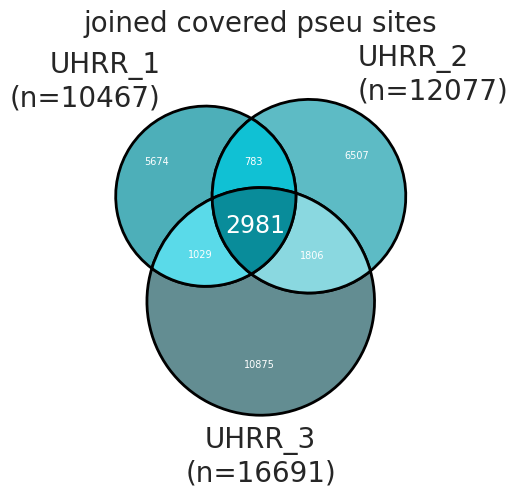

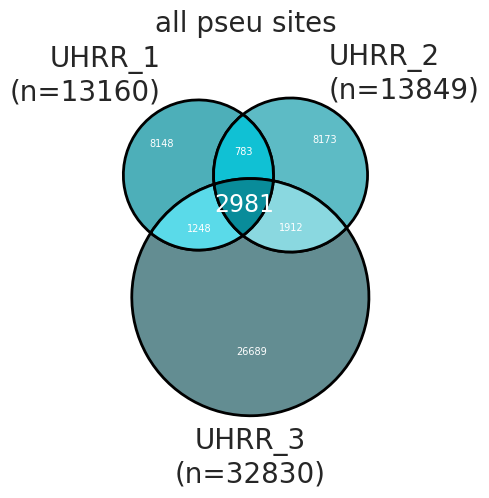

In [46]:
# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
UHRR_1_RNA004_pseu_sites = p_cell_pseu_cov10[(p_cell_pseu_cov10["sample"] == "RNA004_UHRR_1") & (p_cell_pseu_cov10["modRatio"] >= 10)]
UHRR_2_RNA004_pseu_sites = p_cell_pseu_cov10[(p_cell_pseu_cov10["sample"] == "RNA004_UHRR_2") & (p_cell_pseu_cov10["modRatio"] >= 10)]
UHRR_3_RNA004_pseu_sites = p_cell_pseu_cov10[(p_cell_pseu_cov10["sample"] == "RNA004_UHRR_3") & (p_cell_pseu_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
UHRR_1_RNA004_pseu_sites_joined = UHRR_1_RNA004_pseu_sites[(UHRR_1_RNA004_pseu_sites["RNA004_UHRR_2"] >= 10 ) & (UHRR_1_RNA004_pseu_sites["RNA004_UHRR_3"] >= 10)]
UHRR_2_RNA004_pseu_sites_joined = UHRR_2_RNA004_pseu_sites[(UHRR_2_RNA004_pseu_sites["RNA004_UHRR_1"] >= 10 ) & (UHRR_2_RNA004_pseu_sites["RNA004_UHRR_3"] >= 10)]
UHRR_3_RNA004_pseu_sites_joined = UHRR_3_RNA004_pseu_sites[(UHRR_3_RNA004_pseu_sites["RNA004_UHRR_1"] >= 10 ) & (UHRR_3_RNA004_pseu_sites["RNA004_UHRR_2"] >= 10)]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"UHRR_1" : set(UHRR_1_RNA004_pseu_sites_joined.pos), "UHRR_2" : set(UHRR_2_RNA004_pseu_sites_joined.pos), "UHRR_3" : set(UHRR_3_RNA004_pseu_sites_joined.pos)}
plot_overlaps_UHRR(my_dict2 = tmp_dict, title_name = "joined covered pseu sites\n", out_name = "UHRR_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"UHRR_1" : set(UHRR_1_RNA004_pseu_sites.pos), "UHRR_2" : set(UHRR_2_RNA004_pseu_sites.pos), "UHRR_3" : set(UHRR_3_RNA004_pseu_sites.pos)}
plot_overlaps_UHRR(my_dict2 = tmp_dict, title_name = "all pseu sites\n", out_name = "UHRR_all_sites_RNA004_replicates")


### HEK293T

In [41]:
def plot_overlaps_HEK293T(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"

    # Create Venn diagram
    venn = venn2(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('10').set_color("#F5BAAC")   
    venn.get_patch_by_id('01').set_color("#EE6C4D")   
    venn.get_patch_by_id('11').set_color("#EB9782")   

    venn.get_label_by_id('10').set_color("white")   
    venn.get_label_by_id('01').set_color("white")   
    venn.get_label_by_id('11').set_color("white")  

    venn.get_label_by_id('10').set_fontsize(7)
    venn.get_label_by_id('11').set_fontsize(17)
    venn.get_label_by_id('01').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())

    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_HEK293T_RNA004_cov10_freq10_replicates_pseU_" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

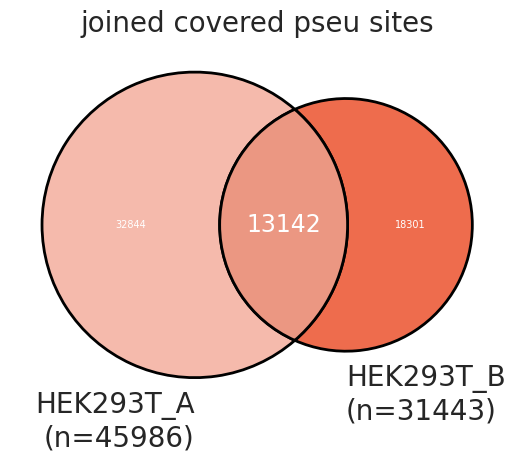

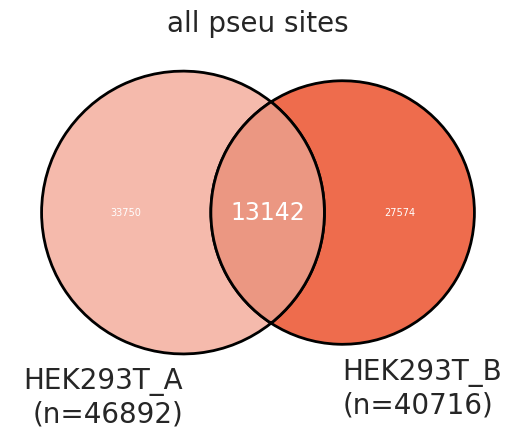

In [44]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn2_circles


# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
HEK_A_RNA004_pseu_sites = p_cell_pseu_cov10[(p_cell_pseu_cov10["sample"] == "RNA004_A") & (p_cell_pseu_cov10["modRatio"] >= 10)]
HEK_B_RNA004_pseu_sites = p_cell_pseu_cov10[(p_cell_pseu_cov10["sample"] == "RNA004_B") & (p_cell_pseu_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with pseu freq >= 10 and RNA002 blood coverage >= 10
HEK_A_RNA004_pseu_sites_joined = HEK_A_RNA004_pseu_sites[HEK_A_RNA004_pseu_sites["RNA004_B"] >= 10 ]
HEK_B_RNA004_pseu_sites_joined = HEK_B_RNA004_pseu_sites[HEK_B_RNA004_pseu_sites["RNA004_A"] >= 10 ]

# Plot overlap between RNA004 joined pseu sites of all three replicates
tmp_dict = {"HEK293T_A" : set(HEK_A_RNA004_pseu_sites_joined.pos), "HEK293T_B" : set(HEK_B_RNA004_pseu_sites_joined.pos)}
plot_overlaps_HEK293T(my_dict2 = tmp_dict, title_name = "joined covered pseu sites", out_name = "HEK293T_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"HEK293T_A" : set(HEK_A_RNA004_pseu_sites.pos), "HEK293T_B" : set(HEK_B_RNA004_pseu_sites.pos)}
plot_overlaps_HEK293T(my_dict2 = tmp_dict, title_name = "all pseu sites", out_name = "HEK293T_all_RNA004_replicates")






# U>C mismatch extraction for high confidence sites

In [11]:
import pandas as pd
# TAVAKOLI HIGH CONFIDENCE SITES 
tava = "/home/jensenone/psu_high_conf_0base.bed"
praise = "/raid/awiercze_analysis/RNA004_REVISION_NAR/PRAISE_pseU_sites.txt"
tava_sites = pd.read_csv(tava, sep = "\t", header = None)
tava_sites["type"] = "Tavakoli et al."
tava_sites.columns = ["Chromosome", "Start", "End", "TAVAKOLI"]
tava_sites["pos"] = tava_sites["Chromosome"].astype(str) + ":" + tava_sites["Start"].astype(str) 
tava_sites_chr20 = tava_sites[tava_sites["Chromosome"] == "chr20"]

# RMBase pseU sites 
cols_mod_file = ["Chrom", #-> Chromosome.
"Start", #-> The starting coordinate.
"End", #-> The end coordinate.
"modID", #-> Unique ID identification.
"Score", #-> Score.
"Strand",# -> The direction of the strand containing this RNA modification site.
"modType", #-> The RNA modification type of this site.
"supportNum", #-> The number of datasets from which identified this RNA modification site.
"supportList", #-> The list of merged-datasets from which identified this RNA modification site.
"supportListSub", #-> The list of datasets from which identified this RNA modification site.
"pubList", #-> The list of pubmeds coorespond to above-mentioned datasets.
"cellList", #-> The list of cells or tissues in which this RNA modification is identified.
"seqTypeList", #-> The list of type of sequencing data of datasets.
"geneID", #-> The list of gene that the RNA modification site reside in.
"transcriptID", #-> The list of transcript that the RNA modification site reside in.
"geneName", #-> Gene name corresponding to the gene ID.
"geneType" ,#-> Gene biotype on which the RNA modification site distribute.
"Region", #-> Gene feature on which the RNA modification site distribute.
"Seq", #-> The sequence is 41-nt long that was extended by an additional 20 nt in both the 5′- and 3′-directions for the modification site.
"motifScore",# -> The 'Motif score' is alignment score to evaluate the accuracy of identified motif regions of pseu. The higher of motif score means a more accurate motif and a more reliable modification site. The range is from 0 to 5.
"conservedSitesList",# -> The list of sites that are conserved with this RNA modification site in other species.
"snoRNA_detailInfo", #-> Details of snoRNA that guide RNA modifications, eg. "U2:25|G|SCARNA2|C/D|snOPY" represents "snoRNA_guideSite", the base of this site, snoRNA name, snoRNA type and source of snoRNA.
"snoRNA_guideSite",# -> The position of the RNA modification site guided by snoRNAs on RNA, eg. "U2:25" means that this RNA modification site is in he 25th position of U2.
"snoRNA_nameList", #-> The list of snoRNAs that guide this RNA modification site.
"snoRNA_dataBase", #-> The source of information of this modification site guided by snoRNAs.
"writerLoc",# -> The genome coordinate of writer binding site. There may be multiple semicolon-separated values that correpond to the informations separated by semicolon in the 27-29 columns.
"writerID",# ->  The list of writer ID that is unique ID.
"writerNameList", #-> The name of writers that catalyze this RNA modification site.
"source"# -> The source ID (sample) of writer.
]
l = pd.read_csv("~/NEW_RNA004_PLOTS/human.hg38.Pseudo.result.col29.bed", sep = "\t", header = None, names = cols_mod_file)
l_mod = l[l["Chrom"].str.contains("chr")]


In [12]:
#query_ranges = pr.PyRanges(tava_sites)
#gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))
#merge4_sub_annot = query_ranges.join(gtf_ranges, how="left")
#tavakoli_annot = merge4_sub_annot.df
#tavakoli_annot["pos_1"] = tavakoli_annot["pos"] + tavakoli_annot["Strand"].astype(str)
#praise_sites = pd.read_csv(praise, sep = "\t")


In [13]:
# All Bam files
bam_files = [
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_2_basecall.0.7.2.GRCh38.bam',
    '/raid/awiercze_analysis/RNA004_UHRR_basecall.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_blood_IVT.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_B_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_blood_IVT.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_blood.0.7.2.GRCh38.bam',
    '/raid/awiercze_analysis/RNA002_UHRR_basecall.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_blood.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_3.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_A_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_A_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_B_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/RNA004_S6_DRS_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S5_analysis_5_12_24/RNA004_S5_DRS_basecall.0.7.2.GRCh38.bam'
    ]

In [15]:
import pysam 
import pandas as pd
import os
def extract_tavakoli_uc_mismatch(bam_file, tava_sites_in):
    p_all = pd.DataFrame()
    samfile = pysam.AlignmentFile(bam_file, "rb")
    for i, row in tava_sites_in.iterrows():
        positions = [row[0], row[1], row[2]]
        n = 0
        C_mismatch = 0
        AUG_mismatch = 0
        for pileupcolumn in samfile.pileup(positions[0], start = positions[1], end = positions[2], truncate = True, max_depth = 10000000, min_base_quality=13): #defaul min_base_qualiy = 13
            out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
            for pileupread in pileupcolumn.pileups:
                mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
                i = pileupread.alignment
                if pileupread.is_del or pileupread.is_refskip:
                    continue
                if i.is_unmapped or i.is_supplementary or i.is_secondary:
                    continue
                if len(mod_pos) > 0:
                    if mod_pos[0][0] == None:
                        continue
                    n = n+1
                    if i.is_reverse:
                        if mod_pos[0][2] == "a":
                            called_base = i.query_sequence[mod_pos[0][0]]
                            if called_base == "G":
                                C_mismatch += 1
                            else:
                                AUG_mismatch += 1
                    else:
                        if mod_pos[0][2] == "t":
                            called_base = i.query_sequence[mod_pos[0][0]]
                            if called_base == "C":
                                C_mismatch += 1
                            else:
                                AUG_mismatch += 1
            new_df = pd.DataFrame({"sample" : os.path.basename(bam_file), "chrom" : positions[0], "chromStart" : positions[1], "n_reads" : n, "C_mismatch" : C_mismatch, "AUG_mismatch" : AUG_mismatch}, index = [0])
            p_all = pd.concat([p_all, new_df], axis = 0)
    return(p_all)

p_complete = pd.DataFrame()
for bam in bam_files:
    print(bam)
    sample_name = os.path.basename(bam).replace(".bam", "")
    p = extract_tavakoli_uc_mismatch(bam, tava_sites_in=l_mod)
    p.to_csv("/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_"+ sample_name + ".csv", index = False)
    p_complete = pd.concat([p_complete, p], axis = 0)
                

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_2_basecall.0.7.2.GRCh38.bam


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5a8610e3d0>>
Traceback (most recent call last):
  File "/home/awiercze/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


/raid/awiercze_analysis/RNA004_UHRR_basecall.GRCh38.bam


[E::hts_open_format] Failed to open file "/raid/awiercze_analysis/RNA004_UHRR_basecall.GRCh38.bam" : No such file or directory


FileNotFoundError: [Errno 2] could not open alignment file `/raid/awiercze_analysis/RNA004_UHRR_basecall.GRCh38.bam`: No such file or directory

### Extract U>C mismatch at Tavakoli sites

In [ ]:
p_complete = pd.DataFrame()
for bam in bam_files:
    print(bam)
    p = extract_tavakoli_uc_mismatch(bam, tava_sites_in=tava_sites)
    p_complete = pd.concat([p_complete, p], axis = 0)

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_2_basecall.0.7.2.GRCh38.bam


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7680a8b2e0>>
Traceback (most recent call last):
  File "/home/awiercze/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [6]:
rmbase_UC_mismatches = ['/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_UHRR_1_basecall.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_S6_DRS_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_blood_IVT.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_UHRR_2_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_B_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_B_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_A_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_blood.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_A_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_blood.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_UHRR_1_basecall.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_S6_IVT_LI_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_S5_DRS_basecall.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_blood_IVT.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_UHRR_3.0.7.2.GRCh38.csv',
 '/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_S6_IVT_basecall.0.7.2.GRCh38.csv']

In [7]:
rmbase_tmp_complete = pd.DataFrame()
for file in rmbase_UC_mismatches:
    print(file)
    rmbase_tmp = pd.read_csv(file)
    rmbase_tmp_complete = pd.concat([rmbase_tmp_complete, rmbase_tmp], axis = 0)

/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_UHRR_1_basecall.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_S6_DRS_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_blood_IVT.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_UHRR_2_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_B_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_B_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_A_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_blood.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA002_A_basecall.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/RMBase_pseu_sites_UC_mismatch_RNA004_blood.0.7.2.GRCh38.csv
/home/awiercze/NEW_RNA004_PLOTS/

In [8]:
rmbase_tmp_complete["sample_flat"] = (
    rmbase_tmp_complete["sample"]
    .str.replace("_A", "_HEK293T_A")
    .str.replace("_B", "_HEK293T_B")
    .str.replace("\..*", "", regex = True)
    .str.replace("_basecall", "", regex = True)
    .str.replace("S5_DRS", "blood_2")
    .str.replace("blood.0.7.2", "blood_1")
    .str.replace("blood_IVT.0.7.2", "blood_IVT_1")
    .str.replace("S6_IVT_LI", "blood_IVT_3_R2")
    .str.replace("S6_IVT", "blood_IVT_3_R1")
    .str.replace("S6_DRS", "blood_3")
    .str.replace("blood$", "blood_1", regex = True)


    )

In [9]:
rmbase_tmp_complete["tissue"] = rmbase_tmp_complete["sample_flat"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
rmbase_tmp_complete["chem_type"] = rmbase_tmp_complete["tissue"].str.replace("_.*$", "", regex=True)
rmbase_tmp_complete["tissue_flat"] = rmbase_tmp_complete["tissue"].str.replace(".*_", "", regex=True)
rmbase_tmp_complete["U>C %"] = (rmbase_tmp_complete["C_mismatch"] / rmbase_tmp_complete["n_reads"]) * 100
rmbase_tmp_complete["ID"] = rmbase_tmp_complete["sample_flat"] + "_" + rmbase_tmp_complete["chrom"] + "_" + rmbase_tmp_complete["chromStart"].astype(str)
rmbase_tmp_complete.set_index("ID", inplace = True)
custom_palette_rna00 = {"RNA002": "#ee6c4d", "RNA004": "#0b3954"}
rmbase_tmp_complete["flowcell_color"] = [custom_palette_rna00[i] for i in rmbase_tmp_complete.chem_type]


In [ ]:
rmbase_tmp_complete.to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_RMBase_pseu_sites_UC_mismatch.tsv", sep = "\t", index = False)

In [12]:
rmbase_tmp_complete.groupby(["chem_type", "tissue_flat"])["U>C %"].mean().to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_RMBase_pseu_sites_UC_mismatch_mean.tsv", sep = "\t")

In [14]:
rmbase_tmp_complete.groupby(["chem_type", "tissue_flat"])["U>C %"].median()

chem_type  tissue_flat
RNA002     HEK293T        0.917431
           IVT            0.000000
           UHRR           0.000000
           blood          0.000000
RNA004     HEK293T        0.000000
           IVT            0.000000
           UHRR           0.000000
           blood          0.000000
Name: U>C %, dtype: float64

/tmp/ipykernel_533141/634659607.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_533141/634659607.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/tmp/ipykernel_533141/634659607.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_533141/634659607.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/tmp/ipykernel_533141/634659607.py:23: Futur

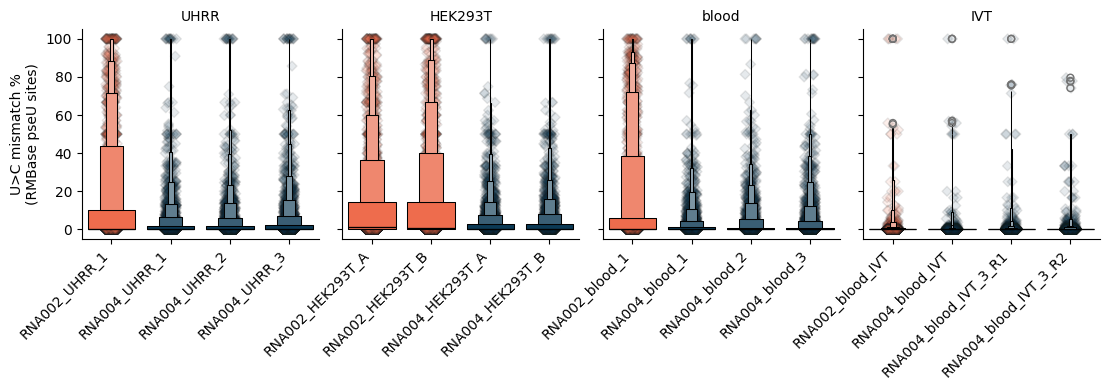

In [ ]:
# Create FacetGrid
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create FacetGrid with proper column wrapping
g = sns.FacetGrid(
    rmbase_tmp_complete,
    col="tissue_flat",
    col_wrap=4,
    sharex=False,
    sharey=True,
    col_order=["UHRR", "HEK293T", "blood", "IVT"],     height=4, 
    aspect=0.7,  
)

# Define plotting function for per-facet sorting
def plot_facet(data, color, **kwargs):
    # Sort samples within each facet
    order = sorted(data["sample_flat"].unique())
    palette = data.set_index("sample_flat")["flowcell_color"].to_dict()

    sns.stripplot(
        data=data,
        x="sample_flat", y="U>C %",
        order=order,
        jitter=True,
        alpha=0.1,
        marker="D",
        linewidth=1,
        palette=palette,
        zorder=0,
        **kwargs
    )
    sns.boxenplot(
        data=data,
        x="sample_flat", y="U>C %",
        order=order,
        linecolor="black",
        saturation=1,
        palette=palette,
        **kwargs
    )

# Apply facet-wise plotting
g.map_dataframe(plot_facet)

# Labeling and formatting
g.set_axis_labels("", "U>C mismatch %\n(RMBase pseU sites)")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
g.fig.subplots_adjust(wspace=0.1, hspace=0.3)

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_pseu_sites_pertissue_sample.svg", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_pseu_sites_pertissue_sample.png", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_pseu_sites_pertissue_sample.pdf", bbox_inches='tight', transparent=True, dpi=300)

/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assign

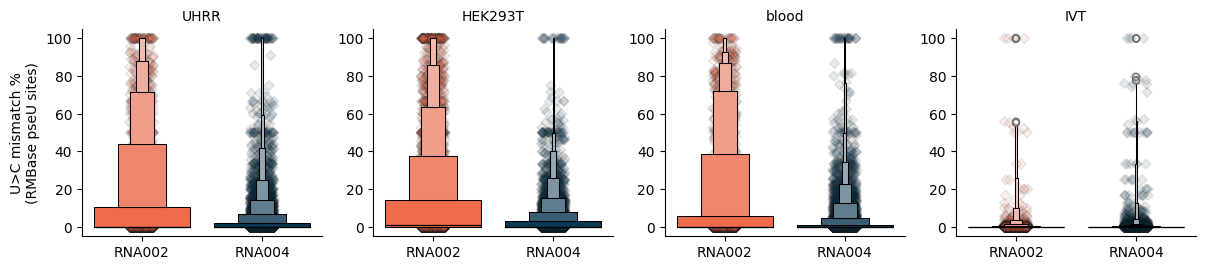

In [ ]:
# Create FacetGrid
g = sns.FacetGrid(
    rmbase_tmp_complete, col="tissue_flat", col_wrap=4, 
    sharex=False, sharey=False, col_order=["UHRR", "HEK293T", "blood", "IVT"] # Adjust plot size
)
g.map_dataframe(sns.stripplot,marker="D", linewidth=1, alpha=.1, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = rmbase_tmp_complete.set_index("chem_type")["flowcell_color"].to_dict(), zorder = 0)
g.map_dataframe(sns.boxenplot, x="chem_type", order = ["RNA002", "RNA004"], linecolor ="black", y="U>C %",saturation=1, palette = rmbase_tmp_complete.set_index("chem_type")["flowcell_color"].to_dict())
g.set_axis_labels("", "U>C mismatch %\n(RMBase pseU sites)")
g.set_titles("{col_name}")  

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_sites_pertissue.svg", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_sites_pertissue.png", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_sites_pertissue.pdf", bbox_inches='tight', transparent=True, dpi=300)

/tmp/ipykernel_533141/3151969064.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax = ax, data=rmbase_tmp_complete,marker="D", linewidth=1, alpha=.4, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = rmbase_tmp_complete.set_index("chem_type")["flowcell_color"].to_dict(),  zorder=0)


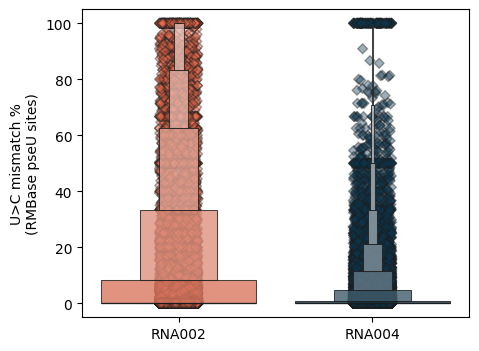

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(5, 4))
sns.stripplot(ax = ax, data=rmbase_tmp_complete,marker="D", linewidth=1, alpha=.4, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = rmbase_tmp_complete.set_index("chem_type")["flowcell_color"].to_dict(),  zorder=0)
sns.boxenplot(ax = ax,data=rmbase_tmp_complete, x="chem_type", y="U>C %", order = ["RNA002", "RNA004"], hue = "chem_type", palette = rmbase_tmp_complete.set_index("chem_type")["flowcell_color"].to_dict(), alpha = 0.8)
ax.set(xlabel = "", ylabel = "U>C mismatch %\n(RMBase pseU sites)")
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_Sites.svg", bbox_inches='tight', transparent=True, dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_Sites.png", bbox_inches='tight', transparent=True, dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_RMBase_Sites.pdf", bbox_inches='tight', transparent=True, dpi=300)



In [ ]:
p_complete["sample_flat"] = (
    p_complete["sample"]
    .str.replace("_A", "_HEK293T_A")
    .str.replace("_B", "_HEK293T_B")
    .str.replace("_basecall.0.7.2.GRCh38.bam", "")
    .str.replace("S5_DRS", "blood_2")
    .str.replace("blood.0.7.2", "blood_1")
    .str.replace("blood_IVT.0.7.2", "blood_IVT_1")
    .str.replace("S6_IVT_LI", "blood_IVT_3_R2")
    .str.replace("S6_IVT", "blood_IVT_3_R1")
    .str.replace("S6_DRS", "blood_3")
    .str.replace(".0.7.2", "")

    )
p_complete["tissue"] = p_complete["sample_flat"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
p_complete["chem_type"] = p_complete["tissue"].str.replace("_.*$", "", regex=True)
p_complete["tissue_flat"] = p_complete["tissue"].str.replace(".*_", "", regex=True)
p_complete["U>C %"] = (p_complete["C_mismatch"] / p_complete["n_reads"]) * 100
p_complete["ID"] = p_complete["sample_flat"] + "_" + p_complete["chrom"] + "_" + p_complete["chromStart"].astype(str)
p_complete.set_index("ID", inplace = True)
custom_palette_rna00 = {"RNA002": "#ee6c4d", "RNA004": "#0b3954"}
p_complete["flowcell_color"] = [custom_palette_rna00[i] for i in p_complete.chem_type]

In [ ]:
p_complete.to_csv("/home/awiercze/NEW_RNA004_PLOTS/Tavakoli_pseu_sites_UC_mismatch.csv", index = False)

### PLOT

/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/awiercze/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assign

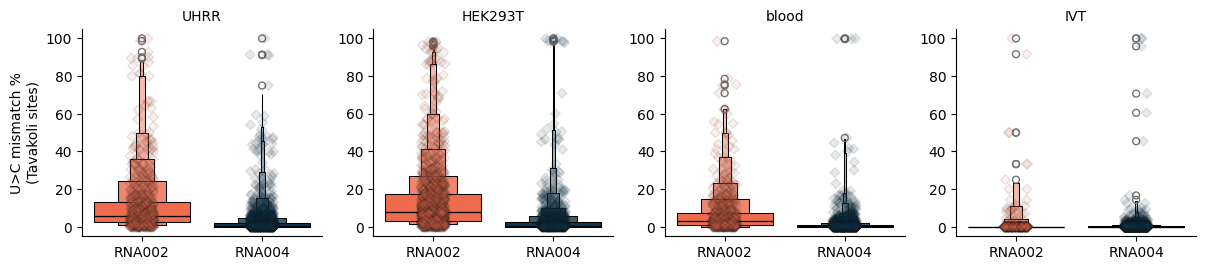

In [ ]:
# Create FacetGrid
g = sns.FacetGrid(
    p_complete, col="tissue_flat", col_wrap=4, 
    sharex=False, sharey=False, col_order=["UHRR", "HEK293T", "blood", "IVT"] # Adjust plot size
)
colors_input = {
"RNA002_HEK293T" :  "#0173b2",
"RNA002_blood" :"#cc78bc", 
"RNA002_blood_IVT" :"#029e73", 
"RNA002_UHRR" : "#d55e00", 
"RNA004_HEK293T" : "#56b4e9", 
"RNA004_blood" :"#ece133", 
"RNA004_blood_IVT" :"#fbafe4", 
"RNA004_UHRR" : "#de8f05",
"Illumina" : "#e9d8a6"}
g.map_dataframe(sns.stripplot,marker="D", linewidth=1, alpha=.1, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = p_complete.set_index("chem_type")["flowcell_color"].to_dict())
g.map_dataframe(sns.boxenplot, x="chem_type", order = ["RNA002", "RNA004"], linecolor ="black", y="U>C %",saturation=1, palette = p_complete.set_index("chem_type")["flowcell_color"].to_dict())
g.set_axis_labels("", "U>C mismatch %\n(Tavakoli sites)")
g.set_titles("{col_name}")  

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_sites_pertissue.svg", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_sites_pertissue.png", bbox_inches='tight', transparent=True, dpi=300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_sites_pertissue.pdf", bbox_inches='tight', transparent=True, dpi=300)



/tmp/ipykernel_2172201/1190035412.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(ax = ax, data=p_complete,marker="D", linewidth=1, alpha=.4, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = p_complete.set_index("chem_type")["flowcell_color"].to_dict(),  zorder=0)


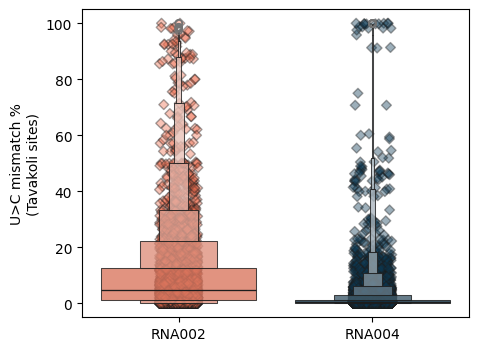

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(5, 4))
sns.stripplot(ax = ax, data=p_complete,marker="D", linewidth=1, alpha=.4, x="chem_type", order = ["RNA002", "RNA004"], y="U>C %",jitter=True,palette = p_complete.set_index("chem_type")["flowcell_color"].to_dict(),  zorder=0)
sns.boxenplot(ax = ax,data=p_complete, x="chem_type", y="U>C %", order = ["RNA002", "RNA004"], hue = "chem_type", palette = p_complete.set_index("chem_type")["flowcell_color"].to_dict(), alpha = 0.8)
ax.set(xlabel = "", ylabel = "U>C mismatch %\n(Tavakoli sites)")
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_Sites.svg", bbox_inches='tight', transparent=True, dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_Sites.png", bbox_inches='tight', transparent=True, dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_UC_mismatch_global_tavakoli_Sites.pdf", bbox_inches='tight', transparent=True, dpi=300)

